# 1. Importing libraries

In [1]:
import torch
from torchvision import transforms
import os
import numpy as np
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from PIL import Image
from torchvision.utils import make_grid

import seaborn as sns
import os
import time 
import random
import argparse

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import pickle
import torch.utils.data as dataUtil
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import warnings
import scipy.misc
import errno
warnings.filterwarnings("ignore") 


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_dir_app = '/kaggle/input/cub-200-bird-pickle-2011'

# 2. Loading and Analysing dataset

## 2.1 Analysing number of images in each sub-directory

In [3]:
def number_of_images(root_dir):
    path_image = root_dir + '/images'
    
    image_subfolders = os.listdir(path_image)
    img = []
    species = []
    image_count = {}
    for image in image_subfolders: 
        count = 0
        species.append(image)
        for ele in os.listdir(os.path.join(path_image, image)): 
            img.append(ele)
            jpg = str.split(ele,'.')
            for name in jpg:
                if name == 'jpg':
                    count=count+1
        image_count[image] = count
        
    return image_count,len(species),len(img)

In [4]:
number_of_bird_each_species, number_species,img_length = number_of_images(base_dir_app + '/birds/CUB_200_2011')

In [5]:
print('Total number of bird species: {}'.format(number_species))
print('Total number of images present: {}'.format(img_length))

Total number of bird species: 200
Total number of images present: 11788


# 3. Implementing StackGAN: Text to Photo-realistic Image Synthesis with Stacked Generative Adversarial Networks paper on CUB-200-2011 dataset

## 3.1 Loading data and Pre - Processing

In [29]:
class BirdDataset(dataUtil.Dataset):
    def __init__(self, dataDir, split='train', imgSize=64, transform=None):
        super(BirdDataset,self).__init__()
        self.transform = transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.imgSize = imgSize
        self.dataDir = dataDir
        self.filenames, self.caps = self.load_info(dataDir, split)
        self.bbox = self.load_bbox()
        self.classes = self.load_class(dataDir, split)
              
    def load_info(self, dataDir, split):
        filenames = self.load_filenames(dataDir, split)
        captionFile = os.path.join(dataDir, 'birds', split, 'char-CNN-RNN-embeddings.pickle')
        with open (captionFile, 'rb') as f:
            captions = pickle.load(f,encoding='latin1')
            captions = np.array(captions)
            print('captions shape: ', captions.shape)
        
        return filenames, captions
        
    def load_filenames(self, dataDir, split):
        path = os.path.join(dataDir, 'birds', split, 'filenames.pickle')
        with open(path, 'rb') as f:
            filenames = pickle.load(f,encoding='latin1')
        print('Load filenames from: %s (%d)' % (path, len(filenames)))
        return filenames
    
    def load_bbox(self):
        path = os.path.join(self.dataDir,'birds','CUB_200_2011', 'bounding_boxes.txt')
        bbox_data = pd.read_csv(path, delim_whitespace=True, header=None).astype(int)

        filepath = os.path.join(self.dataDir,'birds', 'CUB_200_2011','images.txt')
        df_filenames = pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = sorted( list(df_filenames[1]))
        fname_bbox_dict = {x[:-4]:[] for x in filenames} # use filename without '.jpg' extension as a key
        for i in range(len(filenames)):
            data = list(bbox_data.iloc[1][1:])
            k = filenames[i][:-4]
            fname_bbox_dict[k] = data
        return fname_bbox_dict
    
    def load_class(self, dataDir, split):
        path = os.path.join(dataDir, 'birds', split, 'class_info.pickle')
        if os.path.isfile(path):
            with open(path, 'rb') as f:
                classId = pickle.load(f,encoding='latin1')
        else:
            classId = np.arange(len(self.filenames))
        return classId

    def get_img(self, img_path, bbox=None):
        img = Image.open(img_path).convert('RGB')
        width, height = img.size
        if bbox is not None:
            R = int(np.maximum(bbox[2], bbox[3]) * 0.75)
            center_x = int((2 * bbox[0] + bbox[2]) / 2)
            center_y = int((2 * bbox[1] + bbox[3]) / 2)
            y1 = np.maximum(0, center_y - R)
            y2 = np.minimum(height, center_y + R)
            x1 = np.maximum(0, center_x - R)
            x2 = np.minimum(width, center_x + R)
            img = img.crop([x1, y1, x2, y2])
        load_size = int(self.imgSize * 76 / 64)
        img = img.resize((load_size, load_size), Image.BILINEAR)
        if self.transform is not None:
            img = self.transform(img)
        return img

    
    def __getitem__(self, idx):
        key = self.filenames[idx]
        
        if self.bbox is not None:
            bbox = self.bbox[key]
        else:
            bbox = None
        emb = self.caps[idx, :, :]
        imagePath = os.path.join(self.dataDir,'birds', 'CUB_200_2011', 'images',self.filenames[idx]+'.jpg')
        image = self.get_img(imagePath, bbox)
        
        # random select a sentence
        sample = np.random.randint(0, emb.shape[0]-1)
        cap = emb[sample, :]
        return image, cap
    
    def __len__(self):
        return len(self.filenames)

# 4. Model Creation

## 4.1 Stage 1 GAN

### Building Conditioning Augmentation model and  Stage - 1 Generator

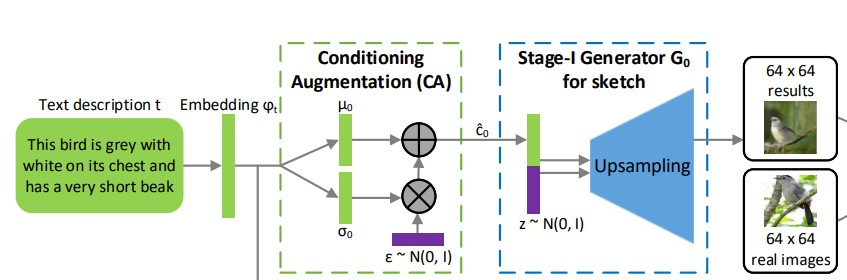

For the generator G0, to obtain text conditioning variable c, the text embedding ϕt is first fed into a fully connected layer to generate µ0 and σ0 (σ0 are the values in the diagonal of Σ0) for the Gaussian distribution N (µ0(ϕt), Σ0(ϕt)). Variable c are then sampled from the Gaussian distribution.



Our Ng dimensional conditioning vector c is computed by c = µ0 + σ0 * ε (where * is the element-wise multiplication, ε ∼ N (0, I)). Then, c is concatenated with a Nz dimensional noise vector to generate a W0 × H0 image by a series of up-sampling blocks.

In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
CUDA = True
cond_dim = 128
df_dim = 128
gf_dim = 128
z_dim = 100
emb_dim = 1024

def Conv_k3(in_p, out_p, stride=1):
    return nn.Conv2d(in_p, out_p, kernel_size=3, stride=stride, padding=1, bias=False)

class Upblock(nn.Module):
    def __init__(self, inp, outp):
        super(Upblock, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = Conv_k3(inp, outp)
        self.batch = nn.BatchNorm2d(outp)
        self.relu = nn.ReLU(True)
        
    def forward(self, x):
        o = self.up(x)
        o = self.relu(self.conv(o))
        o = self.batch(o)
        return o

class D_output(nn.Module):
    def __init__(self, have_cond = True):
        super(D_output, self).__init__()
        self.have_cond = have_cond
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=4),
            nn.Sigmoid()
        )
        if have_cond:
            cond_part = nn.Sequential(
                Conv_k3(in_p=1024+128, out_p=1024),
                nn.BatchNorm2d(1024),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.classifier = torch.nn.Sequential(*(list(cond_part)+list(self.classifier)))
        print(self.classifier)
            
    def forward(self, encoded_image, encoded_cond=None):
        if self.have_cond and encoded_cond is not None:
            cond = encoded_cond.view(-1, 128 , 1, 1)
            cond = cond.repeat(1, 1, 4, 4)
            image_with_cond = torch.cat((encoded_image, cond), 1)
        else:
            image_with_cond = encoded_image
        return self.classifier(image_with_cond).view(-1)

class CondAugment_Model(nn.Module):
    def __init__(self):
        super(CondAugment_Model,self).__init__()
        self.fc = nn.Linear(in_features=emb_dim, out_features=cond_dim*2)
        self.relu = nn.ReLU(True)
        
    def convert(self, embed):
        x = self.relu(self.fc(embed))
        mean, sigma = x[:, : cond_dim], x[:, cond_dim:]
        return mean, sigma
    
    def forward(self, x):
        mean, sigma = self.convert(x)
        diag = torch.exp(sigma*0.5)
        if CUDA:
            normal_dis = (torch.FloatTensor(diag.size()).normal_()).cuda()
        else:
            normal_dis = (torch.FloatTensor(diag.size()).normal_())
        condition = (diag*normal_dis)+mean
        return condition, mean, sigma

In [31]:
        
class G_Stage1(nn.Module):
    def __init__(self):
        super(G_Stage1, self).__init__()
        self.CA = CondAugment_Model()
        self.fc = nn.Sequential(
            nn.Linear(in_features=228, out_features=128*8*4*4, bias=False),
            nn.BatchNorm1d(128*8*4*4),
            nn.ReLU(inplace=True)
        )
        self.img = nn.Sequential(
            Upblock(128*8,64*8),
            Upblock(64*8,32*8),
            Upblock(32*8,16*8),
            Upblock(16*8,8*8),
            Conv_k3(8*8, 3),
            nn.Tanh()
        )
        
    def forward(self, noise, emb):
        cond, mean, sigma = self.CA(emb)
        cond = cond.view(noise.size(0), cond_dim, 1, 1)
        x = torch.cat((noise, cond),1)
        x = x.view(-1, 228)
        o = self.fc(x)
        h_code = o.view(-1, 128*8, 4, 4)
        fake_img = self.img(h_code)
        return fake_img, mean, sigma

### Building  Stage - 1 Discriminator

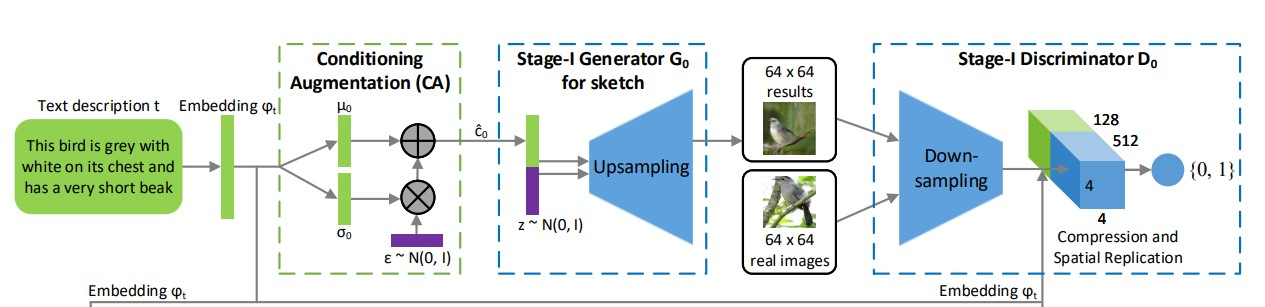

For the discriminator D0, the text embedding ϕt is first compressed to Nd dimensions using a fully-connected layer and then spatially replicated to form a Md × Md × Nd tensor. Meanwhile, the image is fed through a series of down-sampling blocks until it has Md × Md spatial dimension. Then, the image filter map is concatenated along the channel dimension with the text tensor. The resulting tensor is further fed to a 1×1 convolutional layer to jointly learn features across the image and the text. Finally, a fullyconnected layer with one node is used to produce the decision score.

In [32]:
class D_Stage1(nn.Module):
    def __init__(self):
        super(D_Stage1, self).__init__()
        self.encoder = nn.Sequential(
            #c alucalation output size = [(input_size −Kernal +2Padding )/Stride ]+1
            # input is image 3 x 64 x 64  
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),# => 128 x 32 x 32 
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),# => 256 x 16 x 16
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),# => 512 x 8 x 8
            
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)# => 1024 x 4 x 4
        )
        self.condition_classifier = D_output()
        self.uncondition_classifier = None
        
    def forward(self, image):
        return self.encoder(image)

### Building Loss Function

Let ϕt be the text embedding of the given description,which is generated by a pre-trained encoder in this paper. The Gaussian conditioning variables c for text embedding are sampled from N (µ0(ϕt), Σ0(ϕt)) to capture the meaning of ϕt with variations. Conditioned on c and random variable z, Stage-I GAN trains the discriminator D0 and the generator G0 by alternatively maximizing LD0 in Eq. (3) and minimizing LG0 in Eq. (4):




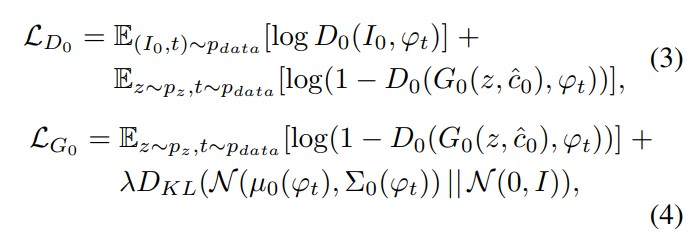

In [33]:
def KL_loss(mean, sigma):
        temp = 1+sigma+((-1)*((mean*mean)+sigma))
        return torch.mean(temp)*(-0.5)

def cal_G_loss(netD, fake_imgs, real_labels, cond):
    criterion = nn.BCELoss()
    cond = cond.detach()
    fake_f = netD(fake_imgs)

    fake_cond_ouput = netD.condition_classifier(fake_f, cond)
    errD_fake = criterion(fake_cond_ouput, real_labels)
    if netD.uncondition_classifier is not None:
        fake_uncond_output = netD.uncondition_classifier(fake_f)
        uncond_errD_fake = criterion(fake_uncond_output, real_labels)
        errD_fake += uncond_errD_fake
    return errD_fake

def cal_D_loss(netD, real_imgs, fake_imgs, real_labels, fake_labels, cond):
    criterion = nn.BCELoss()
    batch_size = real_imgs.size(0)
    cond = cond.detach()
    fake = fake_imgs.detach()

    real_img_feature = netD(real_imgs)
    fake_img_feature = netD(fake)

    real_output = netD.condition_classifier(real_img_feature, cond)
    errD_real  = criterion(real_output, real_labels)
    wrong_output = netD.condition_classifier(real_img_feature[:(batch_size-1)], cond[1:])
    errD_wrong = criterion(wrong_output, fake_labels[1:])

    fake_output = netD.condition_classifier(fake_img_feature, cond)
    errD_fake= criterion(fake_output, fake_labels)

    if netD.uncondition_classifier is not None:
        real_uncond_output = netD.uncondition_classifier(real_img_feature)
        errD_real_uncond = criterion(real_uncond_output, real_labels)

        fake_uncond_output = netD.uncondition_classifier(fake_img_feature)
        errD_fake_uncond = criterion(fake_uncond_output, fake_labels)

        errD = (errD_real+errD_real_uncond)/2. + (errD_fake+errD_wrong+errD_fake_uncond)/3.
        errD_real =  (errD_real+errD_real_uncond)/2
        errD_fake = (errD_fake+errD_fake_uncond)/2.
    else:
        errD = errD_real + (errD_fake+errD_wrong)*0.5
    return errD, errD_real.item(), errD_wrong.item(), errD_fake.item()

### Training Stage - 1 GAN

In [ ]:
#https://github.com/donnaphat-ut/StackGAN
    
def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 64
    transform = transforms.Compose([
                transforms.RandomCrop(64),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    writer = SummaryWriter('runs/Stage-I')

    dataset = BirdDataset(dataDir =  '/kaggle/input/cub-200-bird-pickle-2011', split='train', transform=transform)
    tr_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    netG = G_Stage1().to(device)
    netG.apply(weights_init)
    netD = D_Stage1().to(device)
    netD.apply(weights_init)
    lr = 0.0002
    optD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
    optG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

    fixed_noise = torch.rand(batch_size, z_dim, 1, 1).to(device)

    real_labels = (torch.FloatTensor(batch_size).fill_(1)).to(device)
    fake_labels = (torch.FloatTensor(batch_size).fill_(0)).to(device)
    
    # if not (os.path.isdir('results1/')):
    #     os.makedirs(imageDir)
    num_epoch = 200  #600
    iters = 0
    for epoch in range(num_epoch):
        if epoch % 100 == 0 and epoch > 0:
            lr = lr*0.5
            for param_group in optG.param_groups:
                param_group['lr'] = lr
            for param_group in optD.param_groups:
                param_group['lr'] = lr
        for i, data in enumerate(tr_loader,0):
            real_imgs, encoded_caps = data
            real_imgs = real_imgs.to(device)
            encoded_caps = encoded_caps.to(device)

            ##update discriminator
            netD.zero_grad()
            # generate fake image
            noise = torch.rand(batch_size, z_dim, 1, 1).to(device)
            fake_imgs, m, s = netG(noise, encoded_caps)
            errD, errD_real, errD_wrong, errD_fake = cal_D_loss(netD, real_imgs, fake_imgs, real_labels, fake_labels, m)
            errD.backward()
            optD.step()

            ##update generator
            netG.zero_grad()
            errG = cal_G_loss(netD, fake_imgs, real_labels, m)
            errG += errG + KL_loss(m,s)
            errG.backward()
            optG.step()
            
            iters+=1
            
            writer.add_scalar("gen_loss",errG,epoch)
            writer.add_scalar("disc_loss",errD,epoch)

            if i%50 == 0:
                 print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_D_R: %.4f\tLoss_D_W: %.4f\tLoss_D_F %.4f'
                      % (epoch, num_epoch, i, len(tr_loader),
                         errD.item(), errG.item(), errD_real, errD_wrong, errD_fake))
        if epoch%50==0:
            with torch.no_grad():
                fake, _, _  = netG(fixed_noise, encoded_caps)
                fig = plt.figure(figsize=(10,10))
                grid = make_grid(fake.detach().cpu(), nrow=8, normalize=True).permute(1,2,0).numpy()
                plt.imshow(grid)
                writer.add_image("fake",vutils.make_grid(fake[:64],normalize=True),epoch)
  

                if not os.path.exists("/kaggle/working/result-1"):
                      os.makedirs("/kaggle/working/result-1")
                fig.savefig('/kaggle/working/result-1/epch-{}.png'.format(epoch))

    torch.save(netG.state_dict(), '/kaggle/working/result-1/netG_epoch_600.pth')
    torch.save(netD.state_dict(), '/kaggle/working/result-1/netD_epoch_last.pth')
    
if __name__ == '__main__':
    main()

Load filenames from: /kaggle/input/cub-200-bird-pickle-2011/birds/train/filenames.pickle (8855)
captions shape:  (8855, 10, 1024)
Sequential(
  (0): Conv2d(1152, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(1024, 1, kernel_size=(4, 4), stride=(4, 4))
  (4): Sigmoid()
)
[0/200][0/138]	Loss_D: 1.9024	Loss_G: 0.5301	Loss_D_R: 1.1753	Loss_D_W: 0.7102	Loss_D_F 0.7439
[0/200][50/138]	Loss_D: 1.3439	Loss_G: 4.5202	Loss_D_R: 0.6765	Loss_D_W: 1.1465	Loss_D_F 0.1883
[0/200][100/138]	Loss_D: 1.6267	Loss_G: 5.2683	Loss_D_R: 0.3847	Loss_D_W: 1.7896	Loss_D_F 0.6944
[1/200][0/138]	Loss_D: 1.2570	Loss_G: 4.1417	Loss_D_R: 0.6390	Loss_D_W: 0.9201	Loss_D_F 0.3160
[1/200][50/138]	Loss_D: 1.4308	Loss_G: 2.2047	Loss_D_R: 0.7479	Loss_D_W: 0.7474	Loss_D_F 0.6183
[1/200][100/138]	Loss_D: 1.4882	Loss_G: 3.7432	Loss_D_R: 0.4888	Loss_D_W:

In [ ]:
# %tensorboard --logdir='runs/Stage-I'

### Results Generated at Stage I

#### Epoch 0

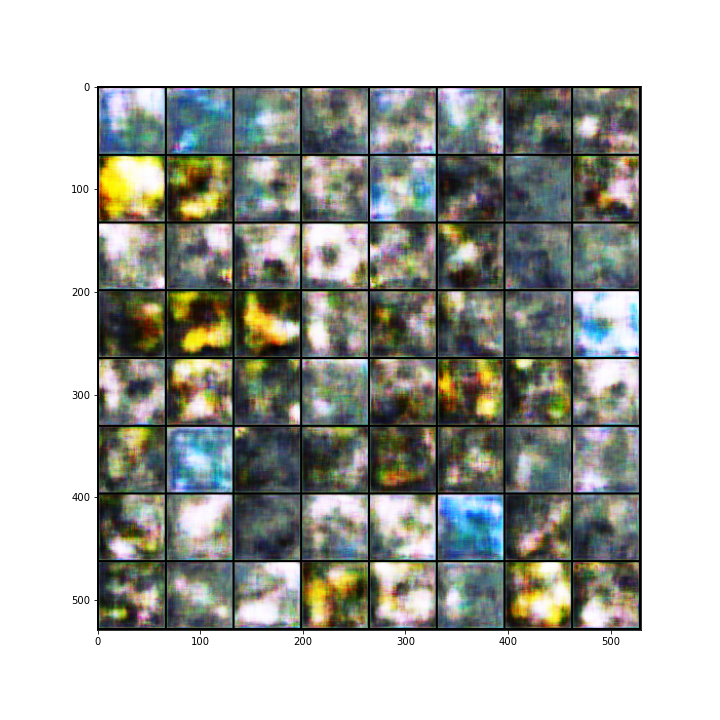

#### Epoch 300

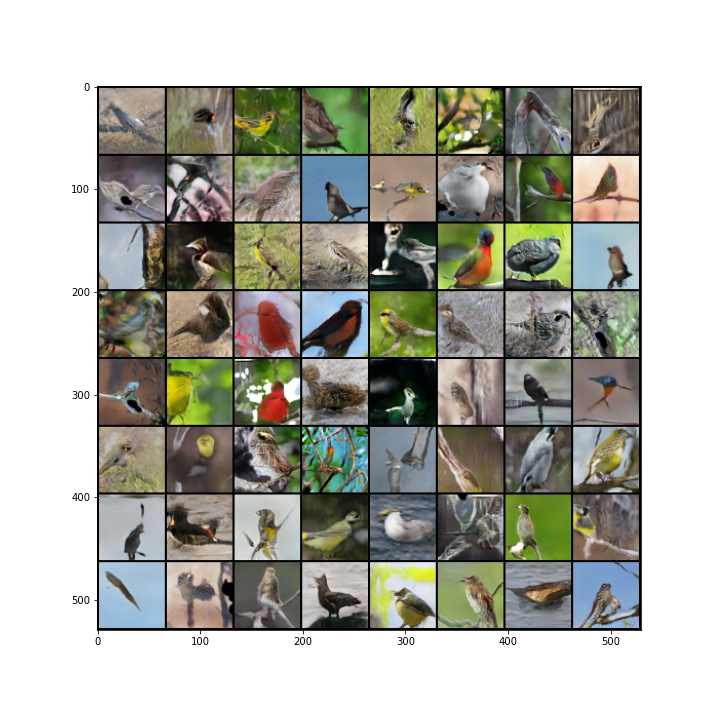

#### Epoch 600

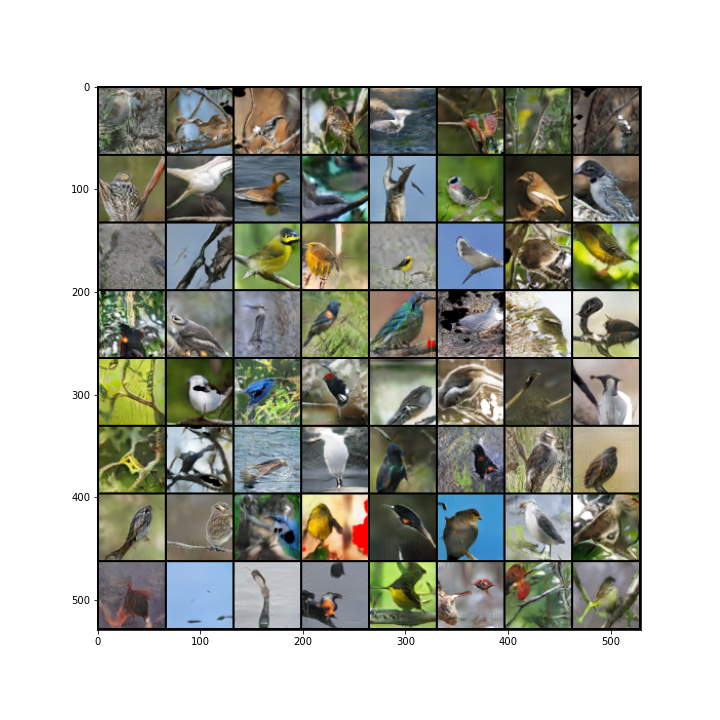

## 4.2 Stage 2 GAN

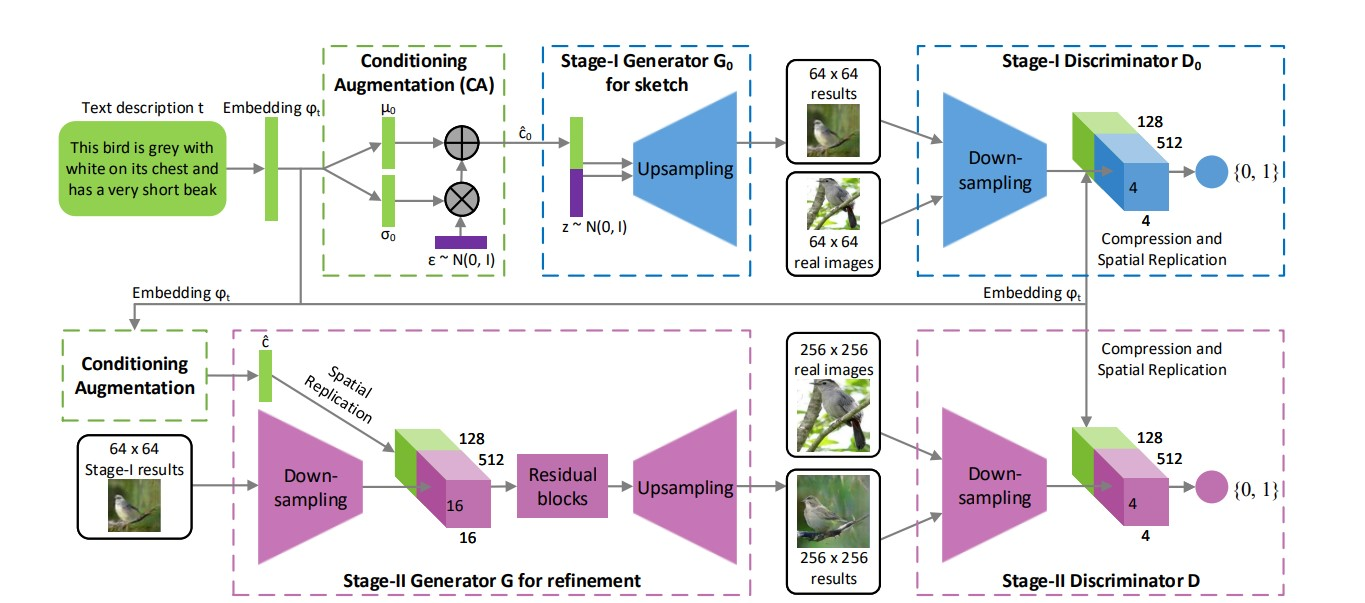

### Building Stage - 2 Generator